# Matrix Factorization Part 0: Singular Value Decomposition

Matrix factorization is an important technique employed in data science for a variety of reasons. This notebook explores the fundamental algorithm that underlies these algorithms, the Singular Value Decompsition (*SVD*). It also shows the relationship between Principal Component Analysis (*PCA*)

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import imageio
import PIL

np.random.seed(42)

Define a few utility functions that will be used throughout the notebook

In [2]:
def generate_correlated_data(x_min, x_max, y_fxn, num_samples, gaussian_noise_sigma):
    arr = np.zeros([num_samples, 2])
    print(arr.shape)
    arr[:, 0] = np.random.uniform(x_min, x_max, num_samples)
    arr[:, 1] = np.apply_along_axis(y_fxn, 0, arr[:, 0]) + np.random.normal(0, gaussian_noise_sigma, num_samples)
    return arr

First, we will generate some strongly correlated data. The underlying data will have the relationship y = 2x, with a bit of gaussian noise.

(1000, 2)


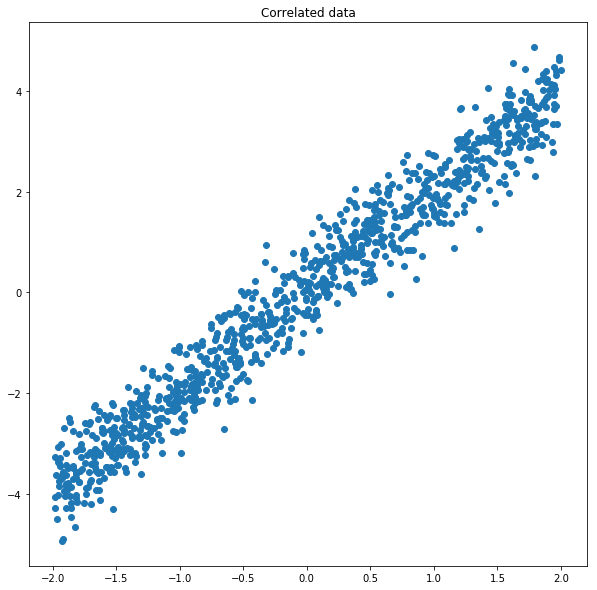

In [3]:
def underlying_correlation_fxn(x):
    return 2*x

gaussian_noise = 0.5
number_data_points = 1000
min_x = -2
max_x = 2

data = generate_correlated_data(min_x, max_x, underlying_correlation_fxn, number_data_points, gaussian_noise)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data[:, 0], data[:, 1])
ax.set_title('Correlated data')
plt.show()

We now perform the Singular Value Decomposition. The SVD is a process that takes a matrix M of dimensions mxn, and factors it into three matricies, U, s, and V. 

* U is a unitary matrix of dimension mxm
* s is a diagonal matrix with strictly positive real values on the trace of dimension mxn 
* V is a unitary matrix of dimension nxn

So, what does that actually mean? In the case where M is a "nice" matrix (real, square, with positive determinant), then the explination for these three factors becomes more intuitive:

* U and V are rotation matricies. They do not "stretch" the space, but rotate objects to face in a different direction.
* s is a "stretching" matrix. It does not rotate objects.

[Wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition) has a very nice illustration of this concept:
![img](images/0/wikipedia_svd.png)

In [4]:
U, s, V = np.linalg.svd(data)

print('The shape of our input data is {0}'.format(data.shape))
print('The shape of U is: {0}'.format(U.shape))
print('The shape of s is: {0}'.format(s.shape))
print('The shape of V is: {0}'.format(V.shape))

print('The singular values are {0}'.format(s))

The shape of our input data is (1000, 2)
The shape of U is: (1000, 1000)
The shape of s is: (2,)
The shape of V is: (2, 2)
The singular values are [83.14506916  6.97268426]


Note: because s is diagonal, numpy returns a 1-d series of the trace rather than computing the entire matrix as a performance optimization.

Our input matrix is not square, and does not have a determininant. However, the visualization above is still useful in understanding the three factors. V still represents a rotation matrix. 

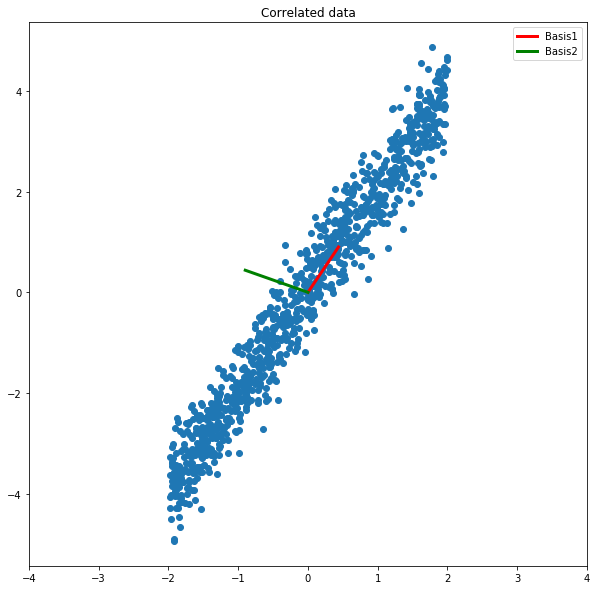

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data[:, 0], data[:, 1])

ax.plot([0, V[0][0]], [0, V[0][1]], 'r-', label='Basis1', linewidth=3.0)
ax.plot([0, V[1][0]], [0, V[1][1]], 'g-', label='Basis2', linewidth=3.0)

ax.set_title('Correlated data')
ax.set_xlim([2*min_x, 2*max_x])
ax.legend()

plt.show()

A few things to point out with this chart:
* The basis vectors are perpendicular. That is, basis_1 • basis_2 = 0. In general, this will be true for U and V - each of the columns will be orthogonal
* The first basis vector points along the direction of maximal variance. This also corresponds to the largest singular value in the s matrix.

This extends to higher dimensions - if we created a 3-d dataset, then we would have three perpendicular basis vectors in V; the first one pointing along the direction of maximum variance, the second pointing along the direction of maximal variance that is also perpendicular to the first, and the third pointing along the direction of maximal variance that is perpendicular to the variance of the first two.

This suggests a use for the SVD. Using these basis vectors, we can determine if a dataset has a low rank representation. This can help eliminate noise and simplify representations of the dataset. As an example, consider an image processing application. We will use the below image as our example.

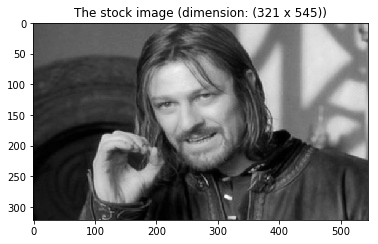

In [6]:
def rgb2gray(image_rgb):
    return np.dot(image_rgb[..., :3], [0.299, 0.587, 0.114])

image_full = imageio.imread('images/0/image.jpg')
image = rgb2gray(image_full)
plt.title('The stock image (dimension: ({0} x {1}))'.format(image.shape[0], image.shape[1]))
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.show()

Perform the SVD of this image, and look at the singular values.

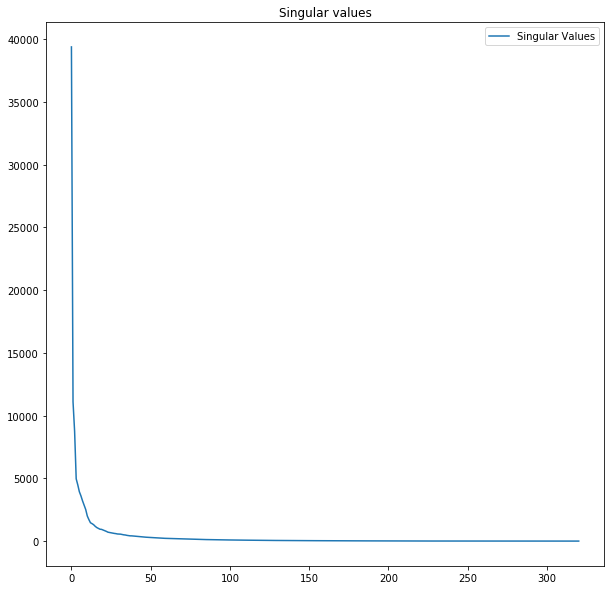

In [7]:
img_U, img_s, img_V = np.linalg.svd(image)

fig, ax = plt.subplots(figsize=(10,10))
xs = range(0, len(img_s), 1)
ys = list(img_s)
ax.plot(xs, ys, label='Singular Values')
plt.title('Singular values')
plt.legend()
plt.show()

It appears as if the bulk of the variance of the image is contained within the first few basis vectors. The first five are shown below.

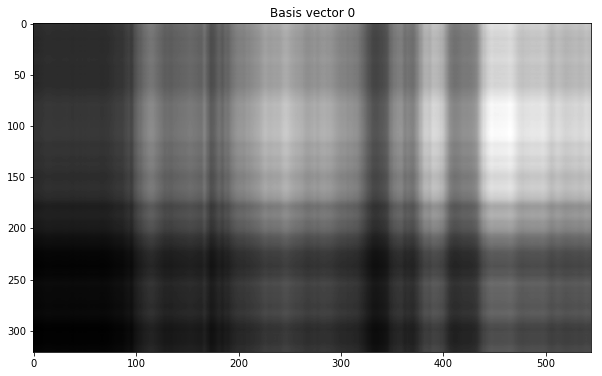

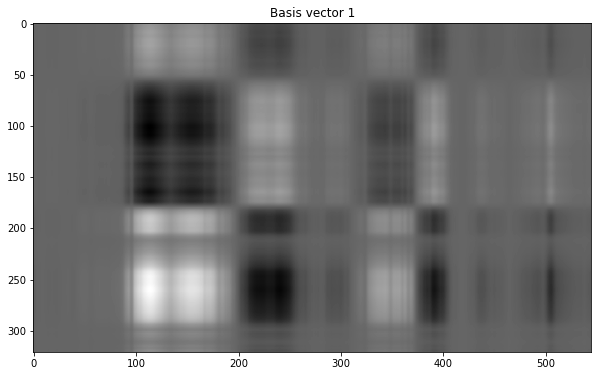

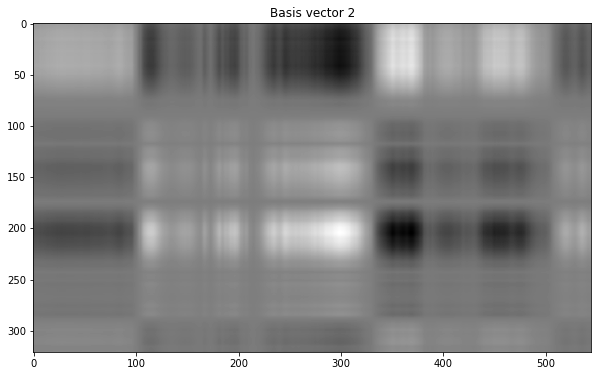

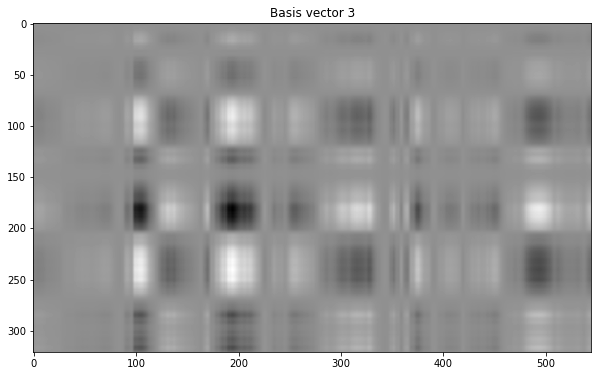

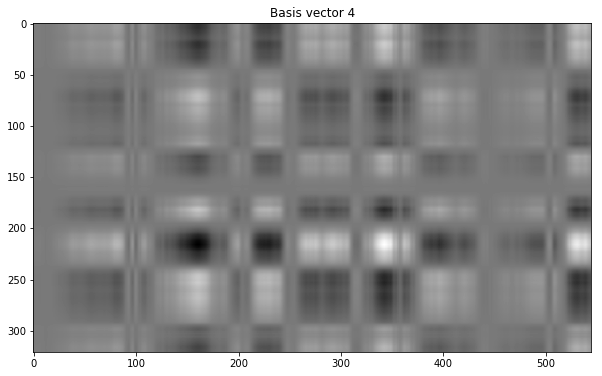

In [8]:
#Numpy requires 1-d column matricies to be explicitly constructed.
def get_basis_vector(i):
    new_u = np.zeros([img_U.shape[1], 1])
    new_u[:, 0] = img_U[:, i]
    new_v = np.zeros([1, img_V.shape[1]])
    new_v[0, :] = img_V[i, :]
    basis_vector = np.matmul(new_u, new_v)
    return basis_vector

for i in range(0, 5, 1):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title('Basis vector {0}'.format(i))
    plt.imshow(get_basis_vector(i), cmap=plt.get_cmap('gray'))
    plt.show()

By combining these basis vectors with their singular values, the image can be reconstructed from suprisingly few vectors.

In [9]:
def recompute_svd(num_basis_vectors):
    svd_fig, svd_ax = plt.subplots(figsize=(10,10))
    output_mat = np.zeros(image.shape)
    for i in range(0, num_basis_vectors, 1):
        output_mat += get_basis_vector(i) * img_s[i]
    
    plt.title('Image with {0} basis vectors'.format(i+1))
    plt.imshow(output_mat, cmap=plt.get_cmap('gray'))
    svd_fig.canvas.draw()
    plt.show()
    
interact(recompute_svd, num_basis_vectors=widgets.IntSlider(min=1, max=50, step=1, value=10, continuous_update=False)) 
print('')

This realization is what drives many image compression applications today. For example, JPEG is essentially an SVD that uses sinusoids as the basis vectors instead of linear vectors. 

A few footnotes:
* The SVD is guaranteed to exist for any matrix. In general, is not unique.
* Note that in our original data matrix, we had our observations in rows. If we had them in columns, then we would look at U for the basis vectors, rather than V
* The details of the singular value decomposition computation are complex, but the basic idea is that
  * The U matrix consists of the eigenvalues of MM†
  * The V matrix consists of the eigenvalues of M†M
  * The diagonal values of the S matrix are the square roots of the eigenvalues of either MM† or M†M, arranged in descending order.
  * For more details on the computation of the SVD, consult the excelent reference on [mit.edu](http://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm)
* Most literature calls the basis vectors 'eigenvectors', and the singular values 'eigenvalues'.
* Computing the exact SVD is quite expensive for large datasets, taking O(mn²) floating point operations. Because of this, many approximate algorithms exist. 
* Principal Component Analysis is a popular dimensionality reduction technique that is essentially synonymous with SVD. The difference is that the data is usually whitened (subtract mean and divide by variance) before performing the SVD. There are also extensions to PCA which allow for nonlinear basis functions (kerneled PCA, or kPCA). 